# CSE378 Programming Assignment 4 -- REINFORCE and Actor-Critic
The goal of this assignment is to implement REINFORCE and Actor-Critic

You will be using 4 Gymnasium environments (InvertedPendulum-v4, Hopper-v4, HalfCheetah-v4, and image-based InvertedPendulum-v4).

###Please only add/change the part surrounded by the marks below
```
#====Please write your codes here======

#======================================
```

###Submission

Please submit the required materials through Brightspace. The instructions are below and they are also available in Brightspace:

- Please find the assignment in attached colab or this link https://colab.research.google.com/drive/15aRx3ijhahGKlKunhyvM-_eylo-kzQvO?usp=sharing. Oh you are actually viewing this colab, good job!

- Please use your **@stonybrook.edu** account to access the assignment colab and edit its copy.

- For submission, please submit **(1) a link to your finished colab and (2) a copy of your colab file.**
  - To get the link and share it, please reach to colab top right -- share->general access->select Stony Brook University, and submit the link in this assignment.
  - To get a copy of your colab, reach to colab top left -- file->download->download .ipynb. The format of the submitted filename will follow \<SBUID\>_\<last name\>_\<first name\>_cse378pa4.ipynb. For example: 123445678_carrot_melon_cse378pa4.ipynb
  - Make sure that once the TA clicks [Run all], the algorithm works and reproduces the results in the submission.

###Grading
- Consider full points of 100.
- REINFORCE algorithm (50 points)
- Actor-Critic algorithm (30 points)
- 8 plots (2 algorithms x 4 environments): the cumulative rewards (Y-axis) vs # of episodes (X-axis), to show the trends of rewards during learning. One plot represents one algorithm under one environment. (20 points in total -- 2.5 point each x 2 algorithms x 4 environments)
- Note on rubric: the assignment will focus on implementing the algorithm correctly. The actual performance, e.g., how much cumulative rewards the algorithms got, are not important.

###Late Submission Policy
The late submission penalty will be 10% grade of that assignment per late day (24 hours). The final grade of a late submitted assignment = (1 - pentalty) * your original grade.
For example, being late for 3 hours will count for 1 day and get 90% of your orignal grade; being late for 1 day + 2 hours will count for 2 days and get 80% of your original grade.




In [27]:
!apt install xvfb -y
!pip install gymnasium[classic-control,atari,accept-rom-license,mujoco]
!pip install opencv-python
%env MUJOCO_GL=egl

'apt' is not recognized as an internal or external command,
operable program or batch file.


You should consider upgrading via the 'c:\python38\python.exe -m pip install --upgrade pip' command.


env: MUJOCO_GL=egl


You should consider upgrading via the 'c:\python38\python.exe -m pip install --upgrade pip' command.


In [20]:
import imageio
from IPython.display import Image, display
from io import BytesIO

# Code for visualizing the episode

class GIFMaker:
    def __init__(self):
        self.reset()

    def reset(self):
        self.images = []
        self.buffer = BytesIO()

    def append(self, img):
        self.images.append(img)

    def display(self):
        imageio.mimsave(self.buffer, self.images, format='gif')
        gif = Image(data=self.buffer.getvalue())
        display(gif)
        return gif

    def __len__(self):
      return len(self.images)

## Env1 InvertedPendulum
Detailed information of this environment:
https://gymnasium.farama.org/environments/mujoco/inverted_pendulum/

In [28]:
import gymnasium as gym
env = gym.make("InvertedPendulum-v4", render_mode="rgb_array")
g = GIFMaker() # visualization
observation, info = env.reset(seed=42)
for i in range(500):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    # print(i, action, observation, reward)
    g.append(env.render()) # save one frame
    if terminated or truncated:
        observation, info = env.reset()
        break
g.display() # show GIF animation
env.close()

DependencyNotInstalled: No module named 'mujoco'. (HINT: you need to install mujoco, run `pip install gymnasium[mujoco]`.)

## Env2 Hopper-v4
Detailed information of this environment:
https://gymnasium.farama.org/environments/mujoco/hopper/

/usr/local/lib/python3.10/dist-packages/ipykernel/ipkernel.py:283: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


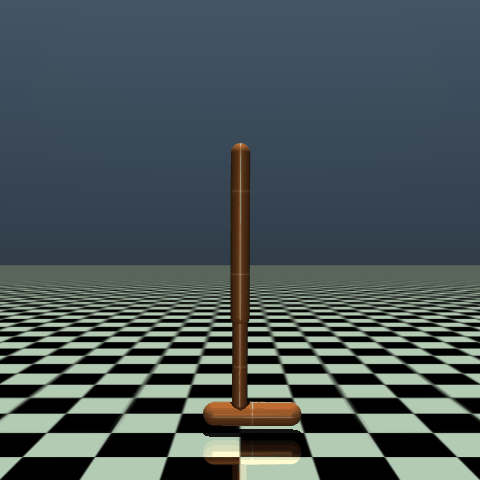

In [ ]:
env = gym.make("Hopper-v4", render_mode="rgb_array")

observation, info = env.reset(seed=42)
g = GIFMaker()
for i in range(200):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    # print(i, action, observation, reward)
    g.append(env.render())
    if terminated or truncated:
        observation, info = env.reset()
        break
g.display()
env.close()

## Env3 HalfCheetah-v4
Detailed information of this environment: https://gymnasium.farama.org/environments/mujoco/half_cheetah/

In [26]:
env = gym.make("HalfCheetah-v4", render_mode="rgb_array")

observation, info = env.reset(seed=42)
g = GIFMaker()
for i in range(200):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    # print(i, action, observation, reward)
    g.append(env.render())
    if terminated or truncated:
        observation, info = env.reset()
        break
g.display()
env.close()

DependencyNotInstalled: No module named 'mujoco'. (HINT: you need to install mujoco, run `pip install gymnasium[mujoco]`.)

## Env4 *Image-based* InvertedPendulum
Detailed information of this environment: https://gymnasium.farama.org/environments/mujoco/inverted_pendulum/

In [25]:
from gymnasium import ObservationWrapper
from gymnasium.wrappers import (
    PixelObservationWrapper,
    GrayScaleObservation,
    ResizeObservation
)
from gymnasium.spaces import Box

class KeyObservationWrapper(ObservationWrapper):
    def __init__(self, env: gym.Env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = self.observation_space['pixels']

    def observation(self, observation):
        return observation['pixels']

class MakeChannelObservationWrapper(ObservationWrapper):
    def __init__(self, env: gym.Env):
        gym.ObservationWrapper.__init__(self, env)
        self.observation_space = Box(
            low = self.observation_space.low[np.newaxis, :],
            high = self.observation_space.high[np.newaxis, :],
            shape = (1,) + self.observation_space.shape,
            dtype = self.observation_space.dtype
        )

    def observation(self, observation):
        return observation[np.newaxis, :]


def make_image_env(env_name):
    env = gym.make(env_name, render_mode="rgb_array")
    env = PixelObservationWrapper(env)
    env = KeyObservationWrapper(env)
    env = GrayScaleObservation(env)
    env = ResizeObservation(env, (84, 84))
    env = MakeChannelObservationWrapper(env)
    return env

env = make_image_env("InvertedPendulum-v4")
observation, info = env.reset(seed=42)
print (observation.shape)
g = GIFMaker()
for i in range(200):
    action = env.action_space.sample()
    observation, reward, terminated, truncated, info = env.step(action)
    # this observation gives you (1, 84, 84), 1 means one gray channel
    # print(i, action, observation, reward)
    # g.append(env.render()) # original rgb frames
    g.append(observation.squeeze(0))    # see the image observations
    if terminated or truncated:
        observation, info = env.reset()
        break
g.display()
env.close()

DependencyNotInstalled: No module named 'mujoco'. (HINT: you need to install mujoco, run `pip install gymnasium[mujoco]`.)

##Import packages we need

In [ ]:
import os
import gc
import math
import random

from tqdm import tqdm
import matplotlib.pyplot as plt
from collections import deque

import numpy as np

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.distributions.normal import Normal

import cv2

##REINFORCE

In [ ]:
# The policy network for numerical states using MLP
class Policy(nn.Module):
    def __init__(
        self,
        state_dim,
        action_dim
    ):
        super(Policy, self).__init__()
        # print(state_dim, action_dim)

        # ====Please write your codes here======

        # ======================================

    def forward(self, x):
        # ====Please write your codes here======

        # ======================================

        x = F.tanh(x) # scale the final output to [-1, 1]; And we treat it as the mean value of a (multi-variable) normal distribution
        return x

# The policy network for **image observations** using CNN
class Policy_Image(nn.Module):
    def __init__(
        self,
        image_channels,
        action_dim
    ):
        super(Policy_Image, self).__init__()
        # ====Please write your codes here======

        # ======================================

    def forward(self, x):
        # ====Please write your codes here======

        # ======================================

        x = F.tanh(x) # scale the final output to [-1, 1]; And we treat it as the mean value of a (multi-variable) normal distribution
        return x


# REINFORCE
class REINFORCE():
    def __init__(
        self,
        env,
        env_name,
        policy_network,
        var=0.1,
        var_decay_steps=20000,
        gamma=0.95,
        lr=0.01
    ):
        # initlize env and env name
        self.env = env
        self.env_name = env_name

        # set state dimension and number of actions
        self.state_dim = env.observation_space.shape
        self.action_dim = env.action_space.shape[0]

        # create policy network:
        if len(self.state_dim) > 1:
            # for image based observations, pass the number of channels of the image
            # here we use grayscaled image so it is 1
            # ====Please write your codes here======
            self.policy_network =
            # ======================================
        else:
            # for numerical states
            self.state_dim = self.state_dim[0]
            # ====Please write your codes here======
            self.policy_network =
            # ======================================


        # assign gpu if avliable
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # move the models to gpu
        self.policy_network = self.policy_network.to(self.device)

        # (end) variance value for normal distribution
        self.var = var
        # how many steps epsilon decays from 1 to eps
        self.var_decay_steps = var_decay_steps

        # set optimizer and make it use "lr" (the learning rate)
        # ====Please write your codes here======
        self.optimizer =
        # ======================================

        # mode is used to switch between optimization and Evaluation
        self.mode = "eval"
        self.total_transitions = 0

        self.gamma = gamma
        self.g = None


    # function to choose action given a state
    # return the log probablity of the action as well
    # return values are all tensors (on gpu if using gpu)
    # Hint: for the log probablity you will use .log_prob() of a pytorch distribution class
    def act(self, state):
        if self.mode == "eval":
            with torch.no_grad():
                # for evaluation
                # let us directly use the mean value as the final action
                # for log probablity, we just give a placeholder value of 0.0
                # ====Please write your codes here======
                action =
                log_prob =
                # ======================================

                return action, log_prob

        elif self.mode == "train":
            # variance of the policy
            # which decays from the initial high value (1) to final value (self.var)
            # this is similar to epsilon decay in DQN
            if self.total_transitions < self.var_decay_steps:
                var = (self.var_decay_steps-self.total_transitions) / self.var_decay_steps * (1 - self.var) + self.var
            else:
                var = self.var

            # we create a normal distribution for action
            # where the mean is the output from the policy network
            # the variance is a constant value
            # (or a value decreases together with eps)
            # Hint: we will use the distribution classes in pytorch
            # "from torch.distributions.normal import Normal" (which is already imported far ahead)
            # ====Please write your codes here======
            mean =  # mean
            var =   # variance
            normal_dist =
            # ======================================

            # sample from the normal distribution as the action
            # ====Please write your codes here======
            action =
            # ======================================

            # let us clip the action to range [-1, 1] in case environment does not accept that
            action = torch.clip(action, -1, 1)

            # get the log probablity of that action according to the normal distribution
            # ====Please write your codes here======
            log_prob =
            # ======================================

        return action, log_prob

    # REINFORCE update
    def optimization(self, log_probs, returns):
        # make the model in train mode
        self.policy_network.train()

        # compute loss using log_probs and returns
        # Hint: log_probs is in size (T, action_dim), T is the steps we experienced
        # we should make it to (T, 1) by taking the mean on the action dimension
        # returns is in size (T, 1)
        # For the final loss, it can be a sum or mean of all the steps, depending on your choice
        # ====Please write your codes here======
        loss =
        # ======================================


        # Optimize the model
        # ====Please write your codes here======

        # ======================================



    # run for one episode
    def run_one_episode(self, visualize=False):
        self.g = GIFMaker()

        terminated = False
        r = 0

        # initialize lists for holding rewards and log_probs we experienced
        # ====Please write your codes here======
        rewards =
        log_probs =
        # ======================================

        # reset the environment
        # ====Please write your codes here======
        state, info =
        # ======================================

        if visualize:
            self.g.append(env.render())

        while not terminated:
            # convert state to tensor
            # make a batch dimension
            # and move it to gpu
            # ====Please write your codes here======
            state_tensor =
            # ======================================


            # choose (sample) an action using self.act()
            # also get its log probability
            # ====Please write your codes here======
            action_tensor, log_prob_tensor =
            # ======================================

            # convert the action tensor to a number for taking a step in environment
            # ====Please write your codes here======
            action =
            # ======================================

            # Go to next state
            # ====Please write your codes here======

            # ======================================
            r += reward # note: r is cumulative reward and reward is this step's reward


            # append the log probability of action to the list for later optimization
            # append this step's reward to rewards list, which will be used to compute future rewards for optimization
            # ====Please write your codes here======

            # ======================================

            # for rendering
            if visualize:
                self.g.append(env.render())

            # inc total_transitions
            if self.mode == "train":
                self.total_transitions += 1

            # Terminated then return
            if terminated or truncated:
                break

            # don't forget to assign next_state to state for the next loop
            state = next_state

        # optimize your policy after this episode ends
        if self.mode == "train":
            # compute the **future rewards** of each step using rewards list
            # Hint: use for loop to create that, sweep from the last reward to the very first
            # Also make it to a tensor of size (T, 1), and move it to gpu
            # T is the length of this trajectory
            # Hint2: don't forget the discount factor
            # ====Please write your codes here======
            # some calculation

            future_rewards =   # it is **not** completing this line only; this is let you know we finally need a variable named future_rewards
            # ======================================

            # make log_probs (currently a list of tensors) to a large tensor as well
            # should be in shape (T, action_dim)
            # ====Please write your codes here======
            log_probs =
            # ======================================


            # optimize your policy by this trajectory
            self.optimization(log_probs, future_rewards)

        # don't forget to return the cumulative reward of this episode
        return r

    def train(self):
        self.mode = "train"
        self.run_one_episode()

    # Evaluation of policy
    def eval(self, n, visualize=False):
        self.mode = "eval" # put in eval mode
        returns = []
        for i in range(n):                          # run evaluation for n episode
            returns.append(self.run_one_episode(visualize))
        return np.mean(returns)                    # return average returns over niter episodes


    # the function called to perform optimization and evaluation
    def execute(self, total_ep=5000, eval_freq=100, eval_ep=100):
        rewards = []   #used to track polciy evaluation across runs
        episodes = []  #number of episodes used to update policy

        prog_bar = tqdm(range(0, total_ep))
        for i in prog_bar:
            self.train()                        # train
            if (i+1) % eval_freq == 0:          # evaluate using eval_ep episodes every eval_freq policy updates
                reward = self.eval(eval_ep)
                rewards.append(reward)
                episodes.append(i)
                print (f"Eval Reward: {reward:.2f} at ep {i+1}")

        plt.plot(episodes, rewards)   #plot evaluation reward vs episodes
        plt.xlabel('episodes')
        plt.ylabel('Rewards')
        plt.title('REINFORCE on '+self.env_name)
        plt.show()

    def visualize(self):
        self.g.display()

In [ ]:
# InvertedPendulum-v4 REINFORCE
gc.collect() # free some unused RAM, don't worry about this
env = gym.make("InvertedPendulum-v4", render_mode="rgb_array")
reinforce = REINFORCE(env, "InvertedPendulum", Policy, var=0.05, lr=1e-3, gamma=0.95) # you can explore different gamma, var (variance of your policy) and learning rate
reinforce.execute(total_ep=10000, eval_freq=400, eval_ep=20) # please train for at least 10000 episodes # roughly around 10 minutes if total_ep=10000, eval_freq=400, eval_ep=20

In [ ]:
# evaluate the final policy (could be slow because it renders images. Be patient)
print (f"Final Eval: {reinforce.eval(20, visualize=True):.2f}")
reinforce.visualize()

In [ ]:
# Hopper-v4 REINFORCE
gc.collect() # free some unused RAM, don't worry about this
env = gym.make("Hopper-v4", render_mode="rgb_array", max_episode_steps=500)
reinforce = REINFORCE(env, "Hopper", Policy, var=0.1, lr=1e-3, gamma=0.98) # you can explore different gamma, var (variance of your policy) and learning rate
reinforce.execute(total_ep=2000, eval_freq=50, eval_ep=10) # please train for at least 2000 episodes # roughly around 10 minutes if total_ep=2000, eval_freq=50, eval_ep=20

In [ ]:
# evaluate the final policy (could be slow because it renders images. Be patient)
print (f"Final Eval: {reinforce.eval(10, visualize=True):.2f}")
reinforce.visualize()

In [ ]:
# HalfCheetah-v4 REINFORCE
gc.collect() # free some unused RAM, don't worry about this
env = gym.make("HalfCheetah-v4", render_mode="rgb_array", max_episode_steps=500)
reinforce = REINFORCE(env, "HalfCheetah", Policy, var=0.05, lr=1e-3, gamma=0.95) # you can explore different gamma, var (variance of your policy) and learning rate
reinforce.execute(total_ep=1000, eval_freq=50, eval_ep=10) # please train for at least 1000 episodes # roughly around 10 minutes if total_ep=1000, eval_freq=50, eval_ep=10

In [ ]:
# evaluate the final policy (could be slow because it renders images. Be patient)
print (f"Final Eval: {reinforce.eval(10, visualize=True):.2f}")
reinforce.visualize()

In [ ]:
# image based InvertedPendulum-v4
env = make_image_env("InvertedPendulum-v4")
gc.collect() # free some unused RAM, don't worry about this
env = gym.make("InvertedPendulum-v4", render_mode="rgb_array")
reinforce = REINFORCE(env, "InvertedPendulum", Policy_Image, var=0.05, lr=1e-3, gamma=0.95) # you can explore different gamma, var (variance of your policy) and learning rate
reinforce.execute(total_ep=5000, eval_freq=200, eval_ep=10) # please train for at least 5000 episodes

#Actor Critic

In [ ]:
# The actor network for numerical states using MLP
class Actor(nn.Module):
    def __init__(
        self,
        state_dim,
        action_dim
    ):
        super(Actor, self).__init__()
        # print(state_dim, action_dim)

        # ====Please write your codes here======

        # ======================================

    def forward(self, x):
        # ====Please write your codes here======

        # ======================================

        x = F.tanh(x) # scale the output to [-1, 1]; And we treat it as the mean value of a (multi-variable) normal distribution
        return x

# The actor network for **image states** using CNN
class Actor_Image(nn.Module):
    def __init__(
        self,
        image_channels,
        action_dim
    ):
        super(Actor_Image, self).__init__()
        # print(state_dim, action_dim)

        # ====Please write your codes here======

        # ======================================

    def forward(self, x):
        # ====Please write your codes here======

        # ======================================
        x = F.tanh(x) # scale the output to [-1, 1]; And we treat it as the mean value of a (multi-variable) normal distribution
        return x


# The critic network for numerical states using MLP
class Critic(nn.Module):
    def __init__(
        self,
        state_dim
    ):
        super(Critic, self).__init__()
        # print(state_dim, action_dim)
        # ====Please write your codes here======

        # ======================================

    def forward(self, x):
        # ====Please write your codes here======

        # ======================================
        return x

# The critic network for **image states** using CNN
class Critic_Image(nn.Module):
    def __init__(
        self,
        image_channels
    ):
        super(Critic_Image, self).__init__()
        # ====Please write your codes here======

        # ======================================

    def forward(self, x):
        # ====Please write your codes here======

        # ======================================
        return x


# ActorCritic
class ActorCritic():
    def __init__(
        self,
        env,
        env_name,
        actor,
        critic,
        var=0.1,
        var_decay_steps=20000,
        train_freq=4,
        target_network_update_freq=200,
        gamma=0.95,
        lr=1e-3
    ):
        # initlize env and env name
        self.env = env
        self.env_name = env_name

        # set state dimension and number of actions
        self.state_dim = env.observation_space.shape
        self.action_dim = env.action_space.shape[0]

        # create actor and critic networks:
        # for critic, also create a target critic network, because we will use it like DQN
        if len(self.state_dim) > 1:
            # for image based observations, pass the number of channels of the image
            # here we use grayscaled image so it is 1
            # ====Please write your codes here======
            self.actor =
            self.critic =
            self.critic_target =
            # ======================================
        else:
            # for numerical states
            self.state_dim = self.state_dim[0]
            # ====Please write your codes here======
            self.actor =
            self.critic =
            self.critic_target =
            # ======================================


        # initialize the target critic network using the weights from critic network
        # ====Please write your codes here======

        # ======================================
        self.critic_target.load_state_dict(self.critic.state_dict())

        # assign gpu if avliable
        self.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

        # move the models to gpu
        # ====Please write your codes here======

        # ======================================

        # (end) variance value for normal distribution
        self.var = var
        # how many steps epsilon decays from 1 to eps
        self.var_decay_steps = var_decay_steps

        # set optimizers, one each network
        # ====Please write your codes here======
        self.actor_optimizer =
        self.critic_optimizer =
        # ======================================

        # mode is used to switch between optimization of DQN and Evaluation
        self.mode = "eval"
        self.total_transitions = 0

        self.gamma = gamma
        self.g = None
        self.train_freq = train_freq
        self.target_network_update_freq = target_network_update_freq


    # function to choose action given a state
    # return the log probablity of the action as well
    # return values are all tensors (on gpu if using gpu)
    # Hint: for the log probablity you will use .log_prob() of a pytorch distribution class
    def act(self, state):
        if self.mode == "eval":
            with torch.no_grad():
                # for evaluation
                # let us directly use the mean value as the final action
                # for log probablity, we just give a placeholder value of 0.0
                # ====Please write your codes here======
                action =
                log_prob =
                # ======================================

                return action, log_prob

        elif self.mode == "train":
            # variance of the policy
            # which decays from the initial high value (1) to final value (self.var)
            # this is similar to epsilon decay in DQN
            if self.total_transitions < self.var_decay_steps:
                var = (self.var_decay_steps-self.total_transitions) / self.var_decay_steps * (1 - self.var) + self.var
            else:
                var = self.var

            # we create a normal distribution for action
            # where the mean is the output from the policy network
            # the variance is a constant value
            # (or a value decreases together with eps)
            # Hint: we will use the distribution classes in pytorch
            # "from torch.distributions.normal import Normal" (which is already imported far ahead)
            # ====Please write your codes here======
            mean =  # mean
            var =   # variance
            normal_dist =
            # ======================================

            # sample from the normal distribution as the action
            # ====Please write your codes here======
            action =
            # ======================================

            # let us clip the action to range [-1, 1] in case environment does not accept that
            action = torch.clip(action, -1, 1)

            # get the log probablity of that action according to the normal distribution
            # ====Please write your codes here======
            log_prob =
            # ======================================

        return action, log_prob

    # optimization
    def optimization(self, log_probs, states, next_states, rewards, not_dones):
        # put the models into training mode
        self.actor.train()
        self.critic.train()


        # make each list of tensors to a large pytorch tensor for optimization
        # here we give the example of log_probs and you will responsible for the rest
        log_probs = torch.cat(log_probs, dim=0)
        # ====Please write your codes here======
        states =
        next_states =
        rewards =
        not_dones =
        # ======================================

        # compute value v(s) and v(s') using critic
        # and advantage
        # Hint: v(s') is from target critic and should not have gradient.
        # Use with torch.no_grad() properly
        # ====Please write your codes here======


        # ======================================


        # compute actor loss
        # Hint: log_probs is in size (T, action_dim)
        # we should make it to (T, 1) by taking the mean on the action dimension
        # For the final loss, it can be a sum or mean of all the steps, depending on your choice
        # Hint2: to compute the actor loss, we should prevent from gradient flowing into critic through advantage
        # we should use .detach() on advantage
        # ====Please write your codes here======

        # ======================================

        # optimize the actor using actor loss
        # ====Please write your codes here======

        # ======================================

        # compute critic loss
        # ====Please write your codes here======

        # ======================================


        # optimize the critic network (not the target critic!)
        # ====Please write your codes here======

        # ======================================


        # update the target critic network based on critic network paramters every self.target_network_update_freq steps
        # ====Please write your codes here======

        # ======================================


    # run for one episode
    def run_one_episode(self, visualize=False):
        self.g = GIFMaker()

        terminated = False
        r = 0

        # make empty lists to hold state, next state, stepwise reward, log probabilities, and not_done
        # ====Please write your codes here======
        states =
        next_states =
        rewards =
        log_probs =
        not_dones =
        # ======================================


        # reset
        # ====Please write your codes here======
        state, info =
        # ======================================

        if visualize:
            self.g.append(env.render())

        while not terminated:
            # make state to tensor, add a batch dimension, and move it to gpu
            # ====Please write your codes here======
            state_tensor =
            # ======================================

            # select (sample) an action and get its log probability
            # ====Please write your codes here======
            action_tensor, log_prob_tensor =
            # ======================================


            # convert action to numpy array for using it in environment
            # ====Please write your codes here======
            action =
            # ======================================

            # go to next state using that action
            # ====Please write your codes here======

            # ======================================

            r += reward

            # for rendering
            if visualize:
                self.g.append(env.render())

            # create tensors for next_state, reward, and not_done
            # remember the batch dimension
            # and move them to gpu
            # ====Please write your codes here======
            next_state_tensor =
            reward_tensor =
            not_done_tensor =
            # ======================================

            if self.mode == "train":
                self.total_transitions += 1

                # if training, append the transition (log probabilities, states, next_states, rewards and not dones)
                # to the lists holding them
                # ====Please write your codes here======

                # ======================================

                # every time we need to train or the trajectory ends
                if (self.total_transitions % self.train_freq) or terminated or truncated:

                    # call optimization
                    self.optimization(log_probs, states, next_states, rewards, not_dones)

                    # reset the lists for holding transitions back to empty lists
                    # ====Please write your codes here======

                    # ======================================

            # terminated then return
            if terminated or truncated:
                return r

            # don't forget to assign next_state to state for the next loop
            state = next_state

    def train(self):
        self.mode = "train"
        self.run_one_episode()

    # Evaluation of policy
    def eval(self, n, visualize=False):
        self.mode = "eval" # put in eval mode
        returns = []
        for i in range(n):                          # run evaluation for n episode
            returns.append(self.run_one_episode(visualize))
        return np.mean(returns)                    # return average returns over niter episodes


    # the function called to perform optimization and evaluation
    def execute(self, total_ep=5000, eval_freq=100, eval_ep=100):
        rewards = []   #used to track polciy evaluation across runs
        episodes = []  #number of episodes used to update policy

        prog_bar = tqdm(range(0, total_ep))
        for i in prog_bar:
            self.train()                        # train
            if (i+1) % eval_freq == 0:          # evaluate using eval_ep episodes every eval_freq policy updates
                reward = self.eval(eval_ep)
                rewards.append(reward)
                episodes.append(i)
                print (f"Eval Reward: {reward:.2f} at ep {i+1}")

        plt.plot(episodes, rewards)   #plot evaluation reward vs episodes
        plt.xlabel('episodes')
        plt.ylabel('Rewards')
        plt.title('Actor Critic on '+self.env_name)
        plt.show()

    def visualize(self):
        self.g.display()

In [ ]:
# InvertedPendulum-v4 Actor-Critic
gc.collect() # free some unused RAM, don't worry about this
env = gym.make("InvertedPendulum-v4", render_mode="rgb_array")
ac = ActorCritic(env, "InvertedPendulum", Actor, Critic, var=0.1, lr=1e-3, train_freq=64) # you can explore different gamma, var (variance of your policy) and learning rate
ac.execute(total_ep=5000, eval_freq=200, eval_ep=20) # run at least 5000 episodes # roughly around 25mins if total_ep=5000, eval_freq=200, eval_ep=20

In [ ]:
# evaluate the final policy (could be slow because it renders images. Be patient)
print (f"Final Eval: {ac.eval(20, visualize=True):.2f}")
ac.visualize()

In [ ]:
# Hopper-v4 Actor-Critic
gc.collect() # free some unused RAM, don't worry about this
env = gym.make("Hopper-v4", render_mode="rgb_array")
ac = ActorCritic(env, "Hopper", Actor, Critic, var=0.1, lr=1e-3, train_freq=32) # you can explore different gamma, var (variance of your policy) and learning rate
ac.execute(total_ep=5000, eval_freq=200, eval_ep=10) # run at least 5000 episodes # roughly around 20mins if total_ep=5000, eval_freq=200, eval_ep=10

In [ ]:
# evaluate the final policy (could be slow because it renders images. Be patient)
print (f"Final Eval: {ac.eval(10, visualize=True):.2f}")
ac.visualize()

In [ ]:
# HalfCheetah-v4 Actor-Critic
gc.collect() # free some unused RAM, don't worry about this
env = gym.make("HalfCheetah-v4", render_mode="rgb_array")
ac = ActorCritic(env, "HalfCheetah", Actor, Critic, var=0.1, , lr=1e-3, train_freq=32, gamma=0.99) # you can explore different gamma, var (variance of your policy) and learning rate
ac.execute(total_ep=600, eval_freq=50, eval_ep=10) # run at least 600 episodes # roughly around 50mins if total_ep=600, eval_freq=50, eval_ep=10

In [ ]:
# evaluate the final policy (could be slow because it renders images. Be patient)
print (f"Final Eval: {ac.eval(10, visualize=True):.2f}")
ac.visualize()

In [ ]:
# image based InvertedPendulum-v4 Actor-Critic
env = make_image_env("InvertedPendulum-v4")
gc.collect() # free some unused RAM, don't worry about this
env = gym.make("InvertedPendulum-v4", render_mode="rgb_array")
ac = ActorCritic(env, "InvertedPendulum", Actor_Image, Critic_Image, var=0.05, lr=1e-3, train_freq=32, gamma=0.95) # you can explore different gamma, var (variance of your policy) and learning rate
ac.execute(total_ep=5000, eval_freq=200, eval_ep=10) # please train for at least 5000 episodes

In [ ]:
# evaluate the final policy (could be slow because it renders images. Be patient)
print (f"Final Eval: {ac.eval(10, visualize=True):.2f}")
ac.visualize()